<h1>Image Cropping and Facial Point Extraction</h1>

Purpose is to walk through all the images and crop the images to a single face of the person of interest. Images are thrown out if no face can be detected. If there are multiple faces, the face closest to the center of the image is used.

Coordinates of facial features and landmarks are saved, because since the image is cropped we may be unable to detect a face from a cropped image.

In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

import os
import dlib
import fnmatch
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2grey
from skimage.transform import resize
from matplotlib.pyplot import imshow 
from scipy.spatial import distance
from scipy.misc import imrotate
from skimage import io
from PIL import Image

<h2>Facial Feature Point Functions</h2>

In [3]:
DATA_PATH = '../../data/'
DATA_LFW_PATH = DATA_PATH + 'lfw/'
DATA_LFW_CROPPED_PATH = DATA_PATH + 'lfw_cropped/'

norm_shape = 230, 230

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(DATA_PATH + 'shape_predictor_68_face_landmarks.dat')

In [5]:
def get_centroid(points):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return (sum(x) / len(points), sum(y) / len(points))
    
def get_facial_feature_points(im, face):
    points = np.array([[p.x, p.y] for p in predictor(im, face).parts()])
    facial_feature_points = [None for i in range(5)]
    
    # Left and right eyes, nose, left and right points of the mouth
    facial_feature_points[0] = get_centroid(np.concatenate((points[37:39], points[40:42])))
    facial_feature_points[1] = get_centroid(np.concatenate((points[43:45], points[46:48])))
    facial_feature_points[2] = points[30]
    facial_feature_points[3] = points[48]
    facial_feature_points[4] = points[54]
    
    return np.array(facial_feature_points)

def get_facial_landmark_points(im, face, w=.6, eye_scale=.05):
    points = np.array([[p.x, p.y] for p in predictor(im, face).parts()])
    landmarks = [None for _ in range(9)]
    
    p = get_centroid([points[19], points[24]])
    dx = p[0] - points[51][0]
    dy = p[1] - points[51][1]

    # Left
    landmarks[0] = points[19]
    
    p = get_centroid(points[40:42])
    landmarks[1] = (p[0] - dx * eye_scale, p[1] - dy * eye_scale)
    
    landmarks[2] = (points[2][0] * (1 - w) + w * points[31][0],
                      points[2][1] * (1 - w) + w * points[31][1])
    
    # Centre
    p = get_centroid([points[19], points[24]])
    landmarks[3] = (p[0] + dx * .1, p[1] + dy * .1)
    landmarks[4] = points[29]
    landmarks[5] = points[51]
    
    # Right
    landmarks[6] = points[24]
    
    p = get_centroid(points[46:48])
    landmarks[7] = (p[0] - dx * eye_scale, p[1] - dy * eye_scale)
    
    landmarks[8] = (points[14][0] * (1 - w) + w * points[35][0],
                      points[14][1] * (1 - w) + w * points[35][1])
    
    return np.array(landmarks)

In [6]:
def get_image_window(image, size, point):
    """
    Assume image is grey image
    """
    top = int(point[1] - size[0] / 2)
    left = int(point[0] - size[1] / 2)
    return image[top:top + size[0], left:left + size[1]]


def get_most_centre_face(image):
    most_centre_face = None
    most_centre_dist = sys.maxint
    
    detected_faces = detector(img, 1)
    for d in detected_faces:
        face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
        centre_dist = distance.euclidean(image_centre, face_centre)
        if centre_dist < most_centre_dist:
            most_centre_dist = centre_dist
            most_centre_face = d
            
    return most_centre_face

def calculate_rotation(points):
    """
    Return degrees of how much the face is rotated off the vertical axis
    """
    u = points[3]
    v = points[5]
    return math.degrees(np.arctan((v[0] - u[0]) / (v[1] - u[1])))

<h2>Extracting Images</h2>

In [7]:
files = []
for root, dirnames, filenames in os.walk(DATA_LFW_PATH):
    for filename in fnmatch.filter(filenames, '*'):
        if not filename.endswith('.DS_Store'):
            files.append(os.path.join(root, filename))

In [8]:
if not os.path.exists(DATA_LFW_CROPPED_PATH):
    os.makedirs(DATA_LFW_CROPPED_PATH)
    
for f in files:
    directory = os.path.dirname(f).replace('/lfw/', '/lfw_cropped/')
    if not os.path.exists(directory):
        os.makedirs(directory)

In [9]:
set([os.path.splitext(f)[1] for f in files])

{'.jpg'}

In [10]:
images = [io.imread(f) for f in files]

In [11]:
set([image.shape for image in images])

{(250, 250, 3)}

In [12]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2

num_images_no_faces_detected = 0
for f, img in zip(files, images):
    # Rotate image
    try:
        face = get_most_centre_face(img)
        landmark_points = get_facial_landmark_points(img, face)
        angle = calculate_rotation(landmark_points)
        img = imrotate(img, -angle)

        # Normalize and cropping image by centering around the facial features
        face = get_most_centre_face(img)
        landmark_points = get_facial_landmark_points(img, face)
        feature_points = get_facial_feature_points(img, face)

        face_height = face.bottom() - face.top()
        face_width = face.right() - face.left()
        scale_height = .5
        scale_width = .5

        left = max(0, face.left() - int(face_width * scale_width))
        top = max(0, face.top() - int(face_height * scale_height))
        right = min(img.shape[1], face.right() + int(face_width * scale_width))
        bottom = min(img.shape[0], face.bottom() + int(face_height * scale_height))

        img = img[top:bottom, left:right]
        landmark_points[:,0] -= left
        landmark_points[:,1] -= top
        feature_points[:,0] -= left
        feature_points[:,1] -= top

        # Resizing image and scaling facial landmark and feature points
        img = rgb2grey(img)            
        img_shape = img.shape
        img = resize(img, norm_shape)

        scale = np.array(norm_shape).astype(float) / np.array(img_shape)
        landmark_points[:,0] = landmark_points[:,0] * scale[1]
        landmark_points[:,1] = landmark_points[:,1] * scale[0]
        feature_points[:,0] = feature_points[:,0] * scale[1]
        feature_points[:,1] = feature_points[:,1] * scale[0]

        # Persisting cropped images and feature / landmark points
        f = f.replace('/lfw/', '/lfw_cropped/')
        np.save(os.path.splitext(f)[0] + '_image.npy', img)
        np.save(os.path.splitext(f)[0] + '_landmarks.npy', landmark_points)
        np.save(os.path.splitext(f)[0] + '_features.npy', feature_points)
    except:
        pass

In [ ]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2

num_images_no_faces_detected = 0
for f, img in zip(files, images):
    
    most_centre_face = None
    most_centre_dist = sys.maxint
        
    detected_faces = detector(img, 1)
    if len(detected_faces) == 0:
        num_images_no_faces_detected += 1
        continue
        
    for d in detected_faces:
        face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
        centre_dist = distance.euclidean(image_centre, face_centre)
        if centre_dist < most_centre_dist:
            most_centre_dist = centre_dist
            most_centre_face = d
    

    image = Image.open(f)  
    f = f.replace('/lfw/', '/lfw_cropped/')
    image_cropped = image.crop((most_centre_face.left(), 
                most_centre_face.top(), 
                most_centre_face.right(), 
                most_centre_face.bottom())
              )
    image_cropped.save(f)
    
    coords = get_facial_feature_points(img, most_centre_face)
    coords[:,0] -= most_centre_face.left()
    coords[:,1] -= most_centre_face.top()

    np.save(os.path.splitext(f)[0] + '.npy', coords)


<h2>Experimental code</h2>
Not actually run to produce the cropped images

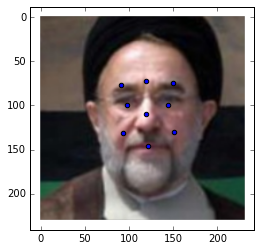

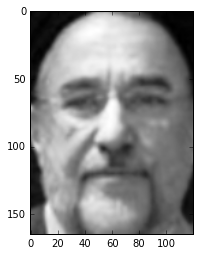

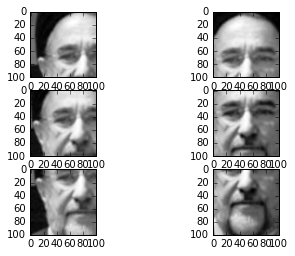

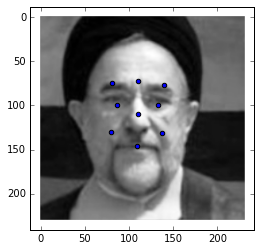

(165, 120)


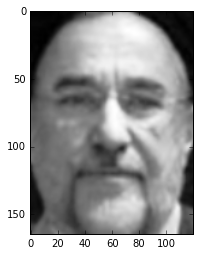

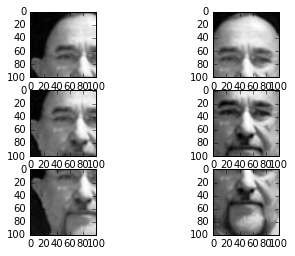

In [201]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2

i = 10
img = images[i]
f = files[i]
image = Image.open(files[i])

# Rotate image
face = get_most_centre_face(rgb2grey(img))
landmark_points = get_facial_landmark_points(img, face)
angle = calculate_rotation(landmark_points)
image = imrotate(image, -angle)
img = imrotate(img, -angle)

# Normalize and cropping image by centering around the facial features
face = get_most_centre_face(img)
landmark_points = get_facial_landmark_points(img, face)
feature_points = get_facial_feature_points(img, face)

face_height = face.bottom() - face.top()
face_width = face.right() - face.left()
scale_height = .5
scale_width = .5

left = max(0, face.left() - int(face_width * scale_width))
top = max(0, face.top() - int(face_height * scale_height))
right = min(img.shape[1], face.right() + int(face_width * scale_width))
bottom = min(img.shape[0], face.bottom() + int(face_height * scale_height))

img = img[top:bottom, left:right]
landmark_points[:,0] -= left
landmark_points[:,1] -= top
feature_points[:,0] -= left
feature_points[:,1] -= top

# Resizing image and scaling facial landmark and feature points
resize_shape = (230, 230, 3)
input_shape = img.shape
resized_image = resize(img, resize_shape)

scale = np.array(resize_shape).astype(float) / np.array(input_shape)
landmark_points[:,0] = landmark_points[:,0] * scale[1]
landmark_points[:,1] = landmark_points[:,1] * scale[0]
feature_points[:,0] = feature_points[:,0] * scale[1]
feature_points[:,1] = feature_points[:,1] * scale[0]

imshow(resized_image)
coord_transpose = np.transpose(landmark_points)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

grey_image = (rgb2grey(resized_image))

# holistic face image
imshow(get_image_window(grey_image, (165, 120), landmark_points[4]), cmap='Greys_r')
plt.show()

# Face patches
fig, ax = plt.subplots(nrows=3, ncols=2)
for i in range(3):
    for j in range(2):
        ax[i][j].imshow(get_image_window(grey_image, (100, 100), landmark_points[3 * j + i]), cmap='Greys_r')
plt.show()

def reflection(image):
    image = np.array([list(reversed(row)) for row in image])
    return image

# Code to handle reflection
grey_image = reflection(rgb2grey(resized_image))
imshow(grey_image, cmap='Greys_r')
landmark_points = [(resize_shape[1] - point[0], point[1]) for point in landmark_points]
landmark_points[:3], landmark_points[6:] = landmark_points[6:], landmark_points[:3]
coord_transpose = np.transpose(landmark_points)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

# holistic face image
im = get_image_window(grey_image, (165, 120), landmark_points[4])
print im.shape
imshow(im, cmap='Greys_r')
plt.show()

# Face patches
fig, ax = plt.subplots(nrows=3, ncols=2)
for i in range(3):
    for j in range(2):
        ax[i][j].imshow(get_image_window(grey_image, (100, 100), landmark_points[3 * j + i]), cmap='Greys_r')
plt.show()

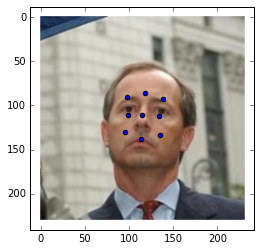

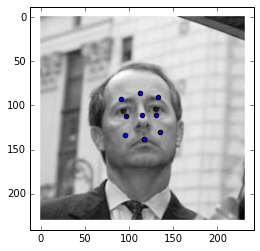

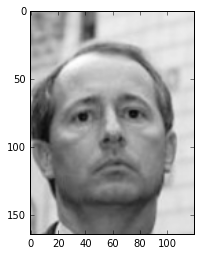

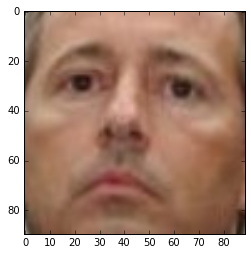

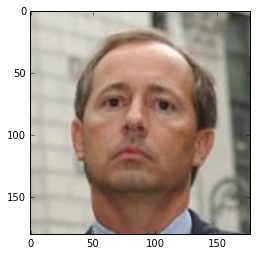

In [189]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2
most_centre_face = None
most_centre_dist = sys.maxint

i = 600
img = images[i]
f = files[i]
image = Image.open(files[i]) 
detected_faces = detector(img, 1)

for d in detected_faces:
    face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
    centre_dist = distance.euclidean(image_centre, face_centre)
    if centre_dist < most_centre_dist:
        most_centre_dist = centre_dist
        most_centre_face = d

        
landmark_points = get_facial_landmark_points(img, most_centre_face)
feature_points = get_facial_landmark_points(img, most_centre_face)

resize_shape = (230, 230, 3)
input_shape = img.shape
resized_image = resize(img, resize_shape)

scale = np.array(resize_shape).astype(float) / np.array(input_shape)
landmark_points[:,0] = landmark_points[:,0] * scale[1]
landmark_points[:,1] = landmark_points[:,1] * scale[0]
feature_points[:,0] = feature_points[:,0] * scale[1]
feature_points[:,1] = feature_points[:,1] * scale[0]

imshow(resized_image)
coord_transpose = np.transpose(landmark_points)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()


def reflection(image):
    image = np.array([list(reversed(row)) for row in image])
    return image

grey_image = reflection(rgb2grey(resized_image))
imshow(grey_image, cmap='Greys_r')
landmark_points = [(resize_shape[1] - point[0], point[1]) for point in landmark_points]
landmark_points[:3], landmark_points[6:] = landmark_points[6:], landmark_points[:3]
coord_transpose = np.transpose(landmark_points)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

imshow(get_image_window(grey_image, (165, 120), landmark_points[4]), cmap='Greys_r')
plt.show()

height = most_centre_face.bottom() - most_centre_face.top()
width = most_centre_face.right() - most_centre_face.left()

scale_height = 0
scale_width = 0

imshow(image.crop((most_centre_face.left() - int(width * scale_width), 
            most_centre_face.top() - int(height * scale_height), 
            most_centre_face.right() + int(width * scale_width), 
            most_centre_face.bottom() + int(height * scale_height))
          ))
plt.show()

scale_height = .5
scale_width = .5

imshow(image.crop((most_centre_face.left() - int(width * scale_width), 
            most_centre_face.top() - int(height * scale_height), 
            most_centre_face.right() + int(width * scale_width), 
            most_centre_face.bottom() + int(height * scale_height))
          ))

In [ ]:
height = images[0].shape[0]
width = images[0].shape[1]
image_centre = width / 2, height / 2
most_centre_face = None
most_centre_dist = sys.maxint

i = 100
img = images[i]
image = Image.open(files[i]) 


detected_faces = detector(img, 1)

for d in detected_faces:
    face_centre = (d.right() + d.left()) / 2, (d.bottom() + d.top()) / 2
    centre_dist = distance.euclidean(image_centre, face_centre)
    if centre_dist < most_centre_dist:
        most_centre_dist = centre_dist
        most_centre_face = d

coords = get_facial_feature_points(img, most_centre_face)
coord_transpose = np.transpose(coords)
imshow(img)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

img_cropped = image.crop((most_centre_face.left(), 
            most_centre_face.top(), 
            most_centre_face.right(), 
            most_centre_face.bottom()))
imshow(img_cropped)
coords[:,0] -= most_centre_face.left()
coords[:,1] -= most_centre_face.top()

coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

f = f.replace('/lfw/', '/lfw_cropped/')
image.crop((most_centre_face.left(), 
            most_centre_face.top(), 
            most_centre_face.right(), 
            most_centre_face.bottom())
          ).save(f)

coord_file = os.path.splitext(f)[0] + '.npy'
np.save(coord_file, coords)

# scale coordinates for image resize
resize_shape = (230, 230, 3)
input_shape = io.imread(f).shape
resized_image = resize(io.imread(f), resize_shape)
imshow(resized_image)

scale = np.array(resize_shape).astype(float) / np.array(input_shape)
coords[:,0] = coords[:,0] * scale[1]
coords[:,1] = coords[:,1] * scale[0]
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()

def reflection(image):
    image = np.array([list(reversed(row)) for row in image])
    return image

imshow(reflection(rgb2grey(resized_image)), cmap='Greys_r')
coords = [(resize_shape[1] - coord[0], coord[1]) for coord in coords]
coord_transpose = np.transpose(coords)
plt.scatter(coord_transpose[0], coord_transpose[1])
plt.show()